In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys
sys.path.append('modeling')
from viz import viz_interactive, viz
from modeling import exponential_modeling
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
import load_data
from plotly.offline import init_notebook_mode, iplot


df = load_data.load_county_level()
df = df.sort_values('tot_deaths', ascending=False)
important_vars = load_data.important_keys(df)
print(df.keys())

Loading BokehJS ...

Index(['id', 'Header-FIPSStandCtyCode', 'EntityofFile',
       'SecondaryEntityOfFile', 'DateofFile', 'DateofCreation', 'FileLength',
       'StateName', 'StateNameAbbreviation', 'CountyName',
       ...
       '#Deaths_3/25/2020', '#Deaths_3/26/2020', '#Deaths_3/27/2020',
       '#Deaths_3/28/2020', '#Deaths_3/29/2020', '#Deaths_3/30/2020', 'deaths',
       'cases', 'tot_deaths', 'tot_cases'],
      dtype='object', length=7331)


## how many deaths/cases are there

In [ ]:
df[['tot_deaths', 'tot_cases', 'StateName', 'CountyName', ]].head(10)

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



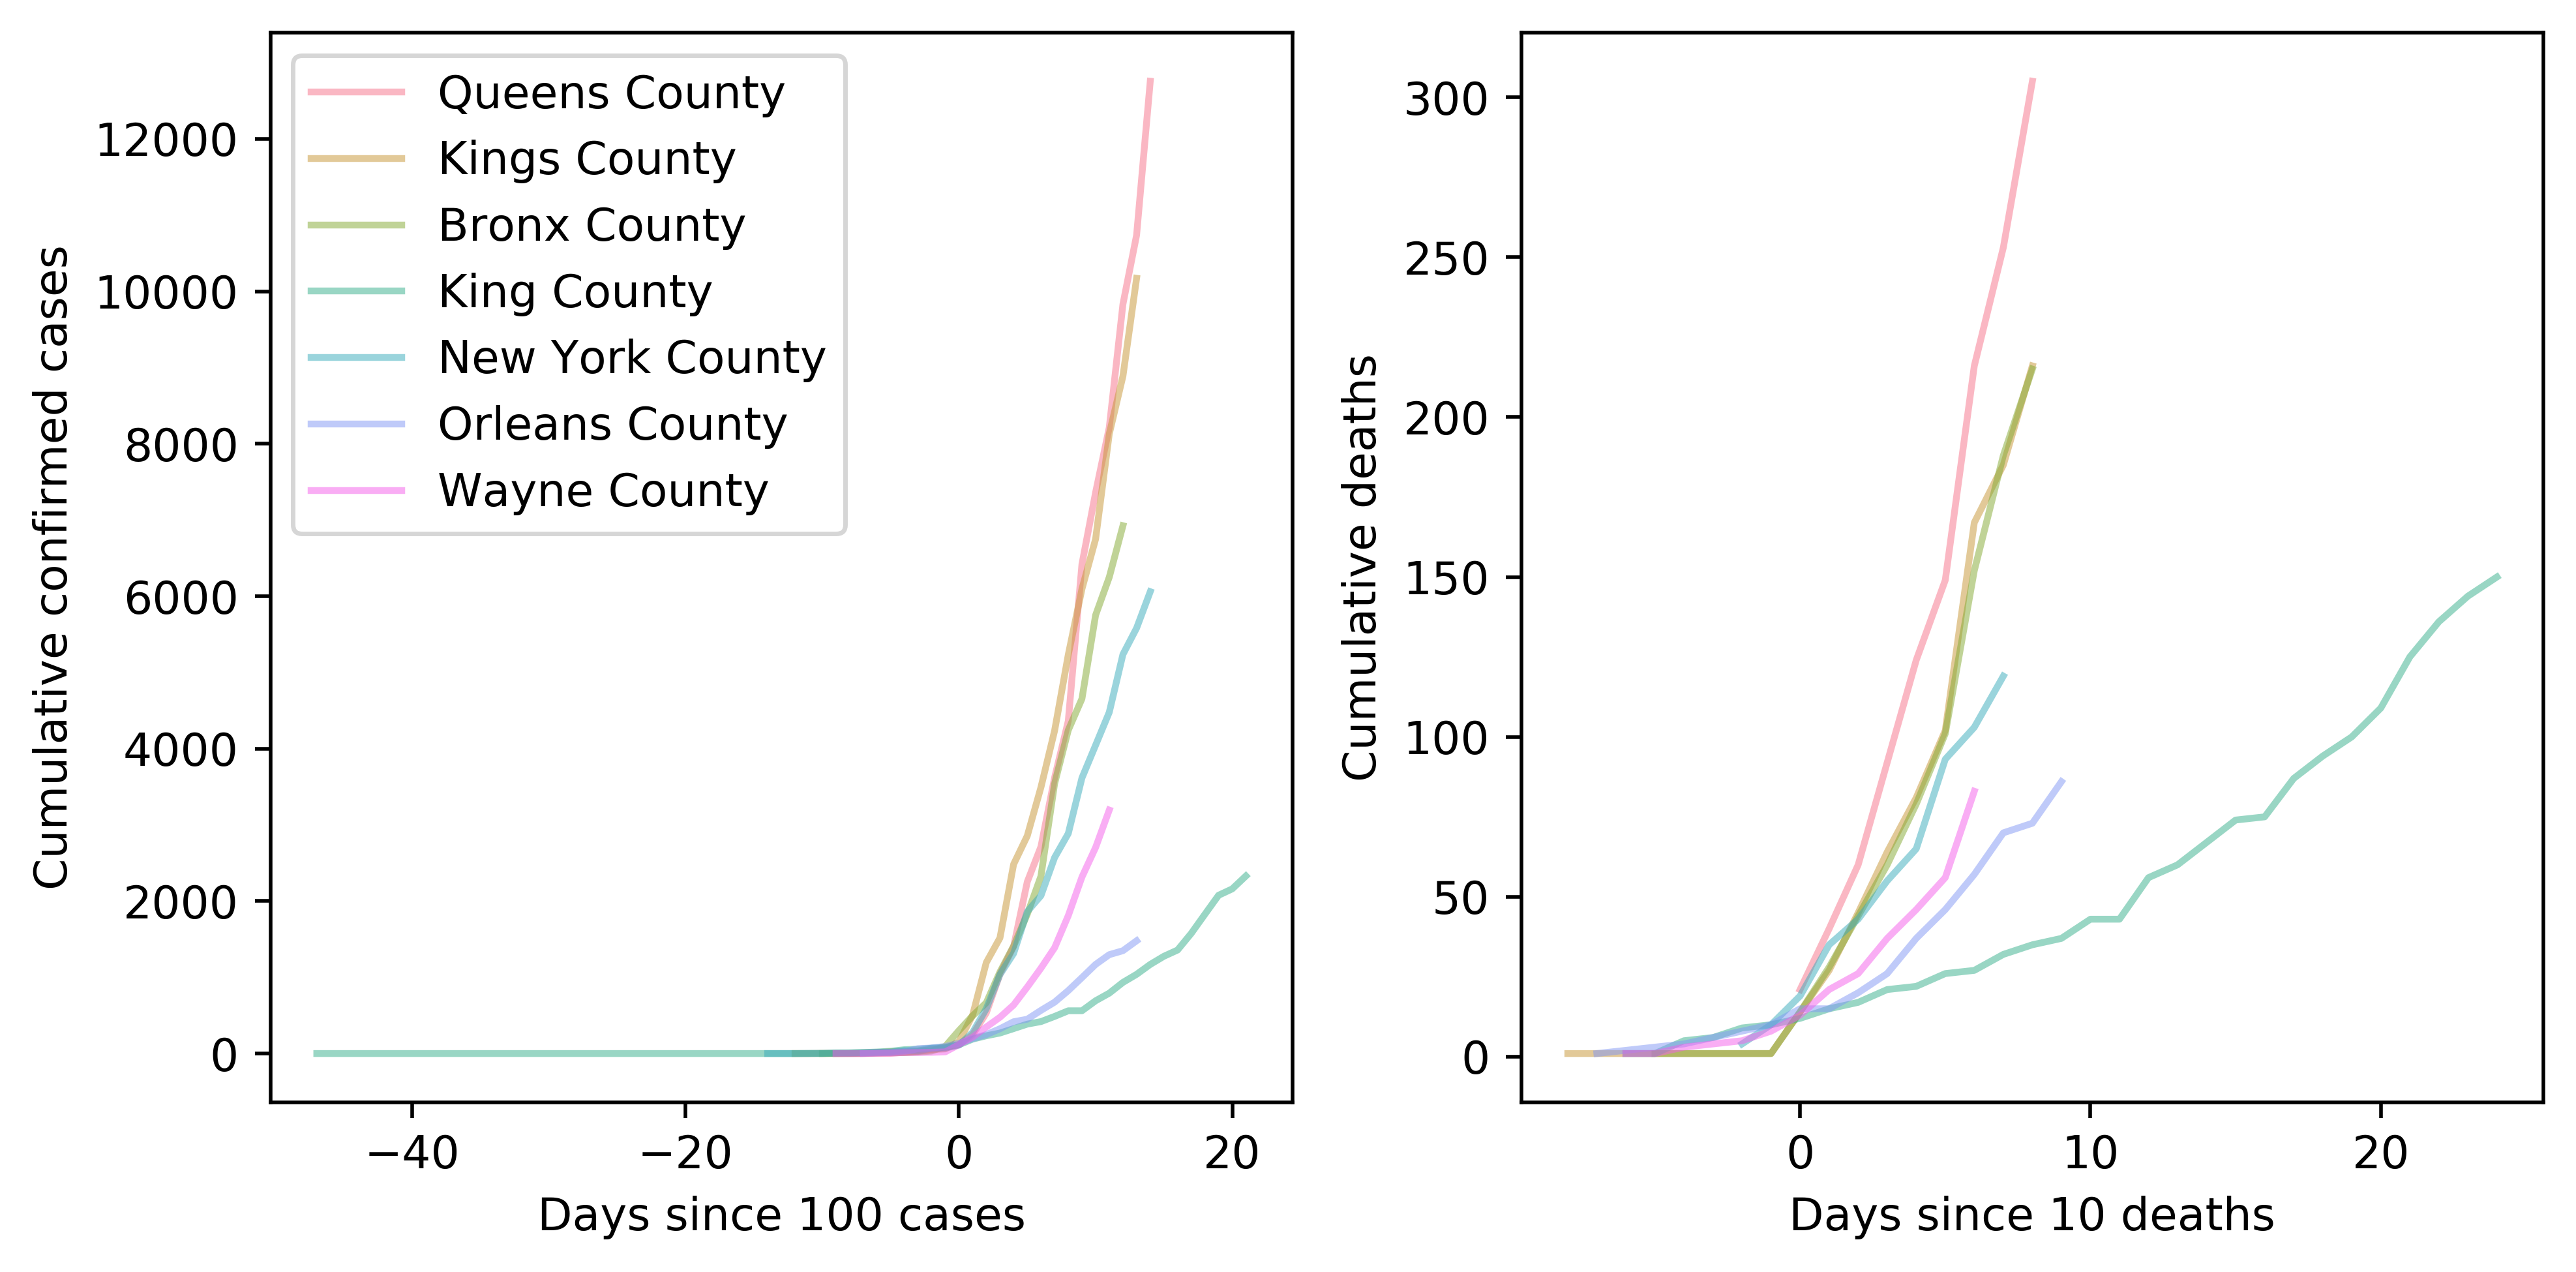

In [3]:
R, C = 1, 2
NUM_COUNTIES = 7
plt.figure(dpi=500, figsize=(8, 4))


# cs = sns.diverging_palette(20, 220, n=NUM_COUNTIES)
cs = sns.color_palette("husl", 7)
for i in range(NUM_COUNTIES):
    row = df.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 10
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 1)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'] + ' County', color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative confirmed cases')
    plt.xlabel(f'Days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 2)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5, color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative deaths')
    plt.xlabel(f'Days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

In [ ]:
d = df[(df['tot_deaths'] > 0) & (df['tot_cases'] > 0)]
R, C = 1, 2
plt.subplot(R, C, 1)
plt.hist(np.log10(d['tot_cases']))
plt.xlabel('Number of cases (log-scale)')
plt.ylabel('Number of counties')
plt.yscale('log')

plt.subplot(R, C, 2)
plt.hist(np.log10(d['tot_deaths']))
plt.xlabel('Number of deaths (log-scale)')
plt.ylabel('Number of counties')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
plt.hist(df['#Hospitals'], bins=100)
plt.xlabel('#Hospitals (per county)')
plt.show()

# correlations

In [ ]:
d = df[[k for k in important_vars if not 'PopMale' in k and not 'PopFmle' in k and not 'MortalityAge' in k and not 'PopTotal' in k] + 
        ['tot_deaths', 'tot_cases']]

viz.corrplot(d)
plt.savefig('results/correlations_heatmap.png')
plt.show()

In [ ]:
keys = np.array(corrs.index)
k = np.where(keys == 'tot_deaths')[0][0]
corrs_row = corrs.iloc[k]
args = np.argsort(corrs_row)
plt.figure(dpi=300, figsize=(6, 5))
plt.barh(keys[args][:-1], corrs_row[args][:-1]) # 1 to drop outcome itself
plt.xlabel('Correlation (spearman) with # deaths')
plt.tight_layout()
plt.savefig('results/correlations.png')
plt.show()

# interactive plots

In [ ]:
ks = [k for k in important_vars if not 'PopMale' in k
      and not 'PopFmle' in k
      and not 'MortalityAge' in k]

**individual states no slider**

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz_interactive.plot_counties(d, 
                          variable_to_distribute='tot_cases',
                          variables_to_display=ks,
                          state=state,
                          logcolor=False)
    
    output_file(f"results/{state}.html", mode='inline')
    show(p)
    save(p)

**counties slider**

In [ ]:
viz_interactive.plot_counties_slider(df, method="ensemble", target_days=np.array([1, 2, 3]), filename="results/deaths.html", cumulative=True)

**political leaning**

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz_interactive.plot_counties(d, 
                          variable_to_distribute='dem_to_rep_ratio',
                          variables_to_display=ks,
                          state=state,
                          logcolor=False)
    show(p)

**viz curves**

In [ ]:
df_tab = df[['tot_deaths', 'tot_cases', 'CountyName', 'StateName', 
             'PopulationDensityperSqMile2010',
             'deaths', 'cases']].head(12)        
# df_tab = df_tab.rename(columns={'PopulationEstimate2018': 'Population\n(thousands})'})
df_tab = df_tab.rename(columns={'PopulationDensityperSqMile2010': 'PopDensity'})
df_tab = df_tab.rename(columns={'tot_deaths': '#Deaths', 'tot_cases': '#Cases'})
df_tab = df_tab.rename(columns={'CountyName': 'County', 'StateName': 'State'})
print(df_tab.keys())
# df_tab['Population']
keys_table = [k for k in df_tab.keys() if not k in ['deaths', 'cases']]
viz_interactive.viz_curves(df_tab, 
               key_toggle='County',
               keys_table=keys_table,
               filename='results/county_curves.html')
print('done!')